# Land Registry Price Paid Data
homework solution by Nikolay Anokhin

In this task I am asked to solve the problem of predicting prices of houses in the UK based of three attributes. I am supposed to suggest a meaningful evaluation metric for my model. To do this one usually needs to understand how the model is to be be used. This information is not given in the task, so I had to invent it. Here's the description of an imaginary estate agent who might use my model:

1. A client who wishes to sell a house asks the agent to help her
2. The agent predicts the price for the house using my model
3. If the client feels that the price is too low (i.e. less than real price - $\delta_1$ pounds), she quits and gives the agent nothing
4. If the house is sold, the client pays the agent a fixed reward of $\varepsilon$ pounds
5. If the house is not sold because the price is too high (i.e. more than real price + $\delta_2$ pounds), the agent gets nothing

Without loss of generality I further assume that $\delta_1 = \delta_2 = \varepsilon = 1000$ pounds. An utility metric suitable for the problem would then be
$$
U(y_{pred}, y_{true}) = \begin{cases}
\varepsilon, \;\; \text{ if } |y_{pred} - y_{true}| < \varepsilon \\
0, \qquad\text{else}
\end{cases}
$$
and the corresponding loss is $L(y_{pred}, y_{true}) = -U(y_{pred}, y_{true}) + \varepsilon$. This loss is hard to optimize, so we replace it with a surrogate SVR loss
$$
L_{svr}(y_{pred}, y_{true}) = \max(0, |y_{pred} - y_{true}| - \varepsilon)
$$
Apart from being convenient to work with, SVR loss is less sensitive to outliers than the squared error loss.

A quick overview of my solution:
1. Shuffle the data to eliminate the initial order and ensure randomness
2. Explore the data
3. Apply one-hot encoding to the given features
4. Inititalize linear model with $L_2$-regularization, trained via optimizing $L_{SVR}$ with SGD
5. Contol utility and loss on the hold-out test set while the model is training

The remainder of this document describes the details. For those not interested in the details, the conclusion is at the very end.

In [2]:
import pandas as pd
import pylab as pl
import seaborn as sns
import dateutil as du
import sklearn.linear_model as slm
import sys

%pylab inline

Populating the interactive namespace from numpy and matplotlib


First of all I implement the expectations the of utility and the SVR loss. Here and further the variables are assumed to be numpy arrays.

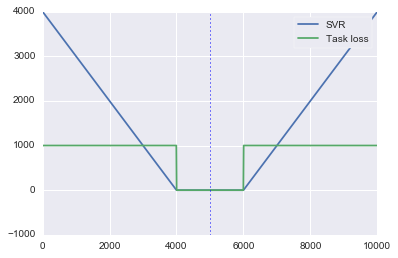

In [3]:
EPSILON=1e+3

def utility(y_pred, y_true, epsilon=EPSILON):
    return 1.0 / y_pred.shape[0] * epsilon * np.sum(np.abs(y_pred-y_true) < epsilon)

def svr_loss(y_pred, y_true, epsilon=EPSILON):
    r = np.abs(y_pred - y_true) - epsilon
    return 1.0 / y_pred.shape[0] * np.sum(r[r > 0])

# Plot the utility-based loss and SVR loss
y_pred = np.linspace(1, 10000, 1000)
y_true = 5000
pl.plot(y_pred, [svr_loss(np.array([y]), np.array([y_true])) for y in y_pred], label='SVR')
pl.plot(y_pred, [-utility(np.array([y]), np.array([y_true])) + EPSILON for y in y_pred], label='Task loss')
pl.axvline(y_true, ls=':', lw=1)
pl.legend(frameon=True)
pl.ylim(-EPSILON, y_true - EPSILON)
pl.show()

The plot above shows that the SVR loss can approximate the task loss.

Before starting to look at the data, I shuffle it to ensure randomness. This will make the SGD more stable, plus it will guarantee existence of test data in each batch. As you can see below, the file is shuffled within reasonable time on my mac book (which is older than XGboost).

In [19]:
%%bash
time gshuf /Users/anokhin/Downloads/pp-complete.csv > /Users/anokhin/Downloads/pp-complete-shuf.csv


real	4m6.845s
user	0m14.363s
sys	0m15.530s


### Exploratory analysis

First I read a small portion of the data set, to find possible values of the attributes and explore the data in general. As this is the toy exercise, the exploration is limited. 

Note that when I read the data, I get rid of the useless columns, and do several transformations to the useful ones.

In [4]:
column_names = [
    "tid",
    "price",
    "is_test",
    "postcode",
    "property_type",
    "old_new",
    "lease_duration",    
    "paon",
    "saon",
    "street", 
    "locality",
    "is_london",
    "district",
    "county",
    "ppd",
    "status"
]

df_explore = pd.read_csv(
    "/Users/anokhin/Downloads/pp-complete-shuf.csv",
    header=None,
    names=column_names,
    index_col=0,    
    usecols=["tid", "price", "is_test", "property_type", "lease_duration", "is_london"],
    nrows=1e+5,
    converters={
        "is_london": lambda s: int("london" in s.lower()),
        "is_test": lambda d: du.parser.parse(d).year >= 2015
    }
)

print "Done reading data frame for exploring: %d train, %d test" % (np.sum(np.logical_not(df_explore["is_test"])), np.sum(df_explore["is_test"]))
    
df_explore.head()

Done reading data frame for exploring: 95792 train, 4208 test


,price,is_test,property_type,lease_duration,is_london
tid,,,,,
{F558B601-B96D-43FE-AD37-C2F188B9F5FC},355000,False,S,F,0
{A2C299E5-8DFE-465E-8B7F-0B4357077E28},105000,False,T,L,0
{4B326D9F-BEBD-410C-BEE2-2F7081F18854},180000,False,F,L,1
{7557B30E-4CD7-4A9A-9B90-6925B4DD7E8A},150000,False,T,F,0
{4C794EA6-DD31-47D4-B0DC-529D30DFEF5A},141000,False,F,L,1


In [5]:
property_types = pd.unique(df_explore["property_type"])
lease_durations = pd.unique(df_explore["lease_duration"])
print "property types: %s, lease durations: %s" % (property_types, lease_durations)

min_price, max_price = df_explore["price"].min(), df_explore["price"].max()
print "minimum price: %d, maximum price: %d" % (min_price, max_price)

property types: ['S' 'T' 'F' 'D' 'O'], lease durations: ['F' 'L' 'U']
minimum price: 5000, maximum price: 23200000


I plot the distribution of the target variable and we immediately see that the distribution looks log-normal. The right plot supports this assumption. I could have built the model for the log-transformed price, but in this case it would be more difficult to reason wheter or not we approximate task loss correctly. Even transforming predictions from log space to initial space is non-trivial. In this exercise I will predict the target directly.

One other thing to notice is that there are outliers, that can be seen even on the right plot. It's nice that SVR loss is robust to outliers, as opposed to squared loss.

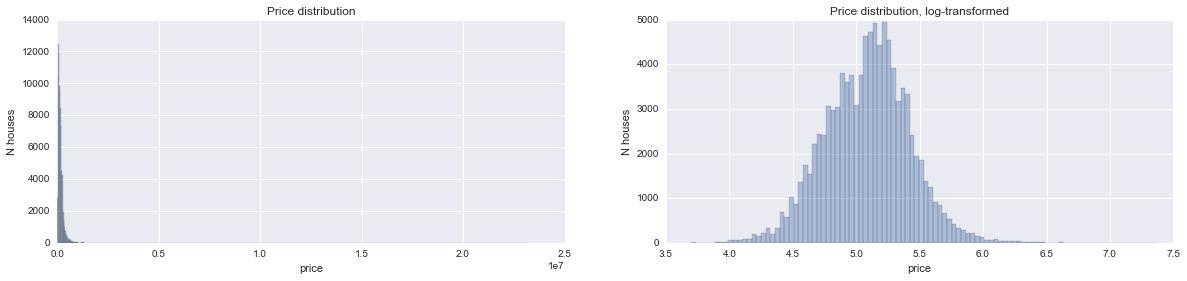

In [6]:
pl.figure(figsize=(20, 4))

pl.subplot(1, 2, 1)
sns.distplot(df_explore["price"], kde=False, bins=1000)
pl.title("Price distribution")
pl.ylabel("N houses")

pl.subplot(1, 2, 2)
sns.distplot(np.log10(df_explore["price"]), kde=False, bins=100)
pl.title("Price distribution, log-transformed")
pl.ylabel("N houses")

pl.show()

For the reference, I compute the baseline prediction: predict average price in any situation.

In [7]:
mean_price = np.mean(np.log10(df_explore["price"]))
y_pred = np.zeros(df_explore.shape[0]) + np.power(10, mean_price)
y_true = df_explore["price"].values

print "Baseline: SVR loss=%.3f, Utility=%.3f" % (svr_loss(y_pred, y_true, EPSILON), utility(y_pred, y_true, EPSILON))

Baseline: SVR loss=92380.048, Utility=6.330


### Training

Below are the auxiliary functions that convert a data frame into numpy arrays, used as train and test data sets.

In [8]:
def one_hot(df, property_types, lease_durations):
    new_columns = set(["is_london"])
    
    for pt in property_types:
        column = "pt_%s" % pt
        df[column] = (df["property_type"] == pt).astype(int)        
        new_columns.add(column)
        
    for ld in lease_durations:
        column = "ld_%s" % ld
        df[column] = (df["lease_duration"] == ld).astype(int)        
        new_columns.add(column)
        
    sorted_columns = sorted(list(new_columns))
    
    return df[sorted_columns].values, sorted_columns

def train_test_split(df, X, Y):
    bool_train = np.logical_not(df["is_test"].values)
    X_train, Y_train = X[bool_train], Y[bool_train]
    
    bool_test = df["is_test"].values
    X_test, Y_test = X[bool_test], Y[bool_test]
                       
    return X_train, Y_train, X_test, Y_test

X, sorted_columns = one_hot(df_explore, property_types, lease_durations)

I will train SGD with batches of data. In order to read the input file in batches, I use pandas again.

In [9]:
BATCH_SIZE = 100

df_reader = pd.read_csv(
    "/Users/anokhin/Downloads/pp-complete-shuf.csv",
    header=None,
    names=column_names,
    index_col=0,    
    usecols=["tid", "price", "is_test", "property_type", "lease_duration", "is_london"],    
    converters={
        "is_london": lambda s: int("london" in s.lower()),
        "is_test": lambda d: du.parser.parse(d).year >= 2015
    },
    chunksize=BATCH_SIZE
)

Next I train the model with 1-epoch pass over all data set. After each batch I compute the SVR loss and the utility function.

Linear models are observed to work well in sparse binary feature spaces. An intuition is that linear models use all the features simultaneously when training a model, as opposed to e.g. tree-based algorithms. That's why the former work better in the datasets where each individual feature does not bear enough information. Again, it's just an intuition so experimentation is still required.

The linear model is $L2$-regularized, because we don't have any requirements to build a sparse model. I skip hyperparameters tuning, as this seems to be outside the scope of this homework. So I pick regularization parameter $\alpha=0.1$ and learning rate $\eta=0.1$, hoping that it will work ok. I use SGD implementation from sklearn: $L_{SVR}$ rorresponds to epsilon insensitive loss. I also apply weight averaging over 50 iterations. 

In [10]:
model = slm.SGDRegressor(loss='epsilon_insensitive', epsilon=EPSILON, penalty='l2', alpha=0.1, learning_rate='constant', eta0=0.1, average=50, shuffle=False, warm_start=True)

loss_train, loss_test = [], []
utility_train, utility_test = [], []
# We limit the current test set with 10k objects
X_test, Y_test, N_test = None, None, 10000
for k, df_chunk in enumerate(df_reader):
    # if k == 10000:
    #     break
    if k % 1000 == 0:
        sys.stdout.write(".")
        
    X = one_hot(df_chunk, property_types, lease_durations)[0]
    Y = df_chunk["price"].values
    X_tr, Y_tr, X_te, Y_te = train_test_split(df_chunk, X, Y)   
    
    X_test = np.vstack([X_test, X_te])[-N_test:] if X_test is not None else X_te
    Y_test = np.hstack([Y_test, Y_te])[-N_test:] if Y_test is not None else Y_te    
    
    model.partial_fit(X_tr, Y_tr)
    
    loss_train.append(svr_loss(model.predict(X_tr), Y_tr, EPSILON))
    loss_test.append(svr_loss(model.predict(X_test), Y_test, EPSILON))
    
    utility_train.append(utility(model.predict(X_tr), Y_tr, EPSILON))
    utility_test.append(utility(model.predict(X_test), Y_test, EPSILON))

...............................................................................................................................................................................................................

The plots below show how the optimized loss and the utlility behave during the training on train and test sets. The train test shows larger volatility because of the small batch sizes. The loss on both sets decreases, although not dramatically after iteration 50000. Same applies to the growth of utility.

Model weights: [('is_london', 0.48704453481232202), ('ld_F', 0.68328073763328512), ('ld_L', -0.055982199199351906), ('ld_U', 3.035951126043905e-05), ('pt_D', 1.1189656178694594), ('pt_F', 0.13578024006066045), ('pt_O', 0.0045782142993315619), ('pt_S', -0.0228201130803251), ('pt_T', -0.60917506120390541)]
Model intercept: [ 117252.24197067]


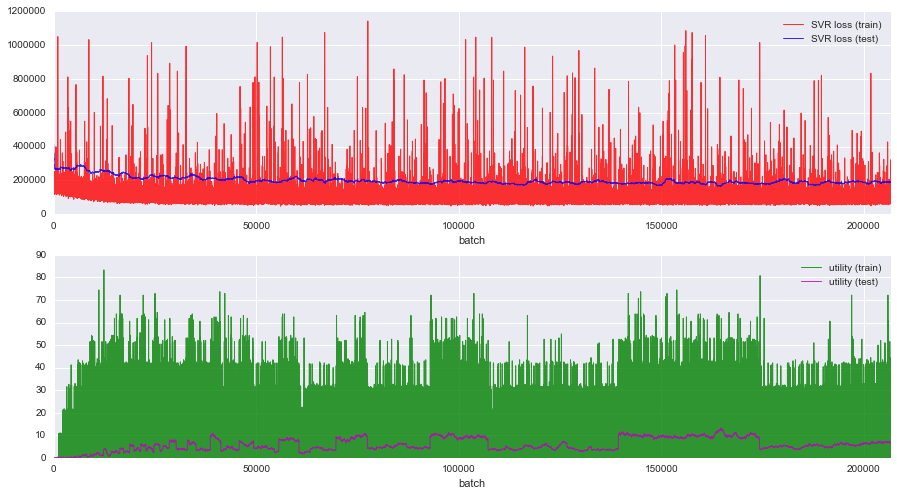

In [15]:
print "Model weights: %s" % zip(sorted_columns, model.average_coef_)
print "Model intercept: %s" % model.average_intercept_

pl.figure(figsize=(15, 8))

pl.subplot(2, 1, 1)
pl.plot(loss_train, 'r', lw=1, alpha=0.8, label="SVR loss (train)")
pl.plot(loss_test, 'b', lw=1, alpha=0.8, label="SVR loss (test)")
pl.xlim(0, len(loss_test))
pl.legend()
pl.xlabel("batch")

pl.subplot(2, 1, 2)
pl.plot(utility_train, 'g', lw=1, alpha=0.8, label="utility (train)")
pl.plot(utility_test, 'm', lw=1, alpha=0.8, label="utility (test)")
pl.xlim(0, len(utility_test))
pl.legend()
pl.xlabel("batch")

pl.show()

### Conclusion

The plots above show that the model gives at most 10 pounds of utility per object, so using this model in production is probably not good idea. I assume that operational costs exceed 10 pounds per attempt, so the enterprise is not profitable.

To improve the solution I would suggest the following:
- The plots above show that the trainig loss is generally lower than the test loss, thus the model is probably underfit. Training for several more epochs could help as well as hyperparameter tuning.
- Exploring feature interactions would increase the probability of linear separability of the data.
- There's always the option of using other types of models.